In [3]:
!pip install tsfel
!pip install pandas
!pip install numpy
!pip install sci-kit learn
!pip install matplotlib
import pandas as pd
import numpy as np
from itertools import product
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt

ERROR: Could not find a version that satisfies the requirement sci-kit (from versions: none)
ERROR: No matching distribution found for sci-kit


In [4]:
X_test = np.array(np.load('../X_test.npy'))
X_train = np.array(np.load('../X_train.npy'))
y_test = np.array(np.load('../y_test.npy'))
y_train = np.array(np.load('../y_train.npy'))

In [6]:
y_train

array([2, 6, 5, 2, 2, 2, 1, 1, 5, 4, 1, 4, 1, 1, 6, 2, 3, 1, 1, 4, 3, 3,
       5, 6, 5, 1, 3, 6, 4, 5, 5, 2, 5, 1, 1, 6, 4, 3, 3, 3, 3, 4, 6, 3,
       4, 1, 2, 2, 6, 5, 5, 3, 6, 6, 4, 3, 4, 2, 4, 5, 5, 5, 5, 4, 6, 6,
       4, 5, 3, 4, 3, 1, 4, 4, 3, 1, 5, 2, 3, 6, 1, 4, 2, 2, 5, 2, 1, 3,
       6, 6, 2, 5, 6, 1, 3, 5, 2, 3, 4, 4, 2, 5, 1, 1, 1, 3, 4, 5, 6, 1,
       3, 6, 5, 4, 2, 2, 6, 2, 6, 6, 3, 1, 4, 6, 2, 2])

In [5]:
X_train

array([[[ 1.19648   , -0.1606898 , -0.740178  ],
        [ 1.22203   , -0.2672951 , -0.7717485 ],
        [ 1.22311   , -0.4338634 , -0.7678422 ],
        ...,
        [ 0.4974957 , -0.2795907 , -0.2029592 ],
        [ 0.5064167 , -0.286091  , -0.2564634 ],
        [ 0.5609918 , -0.302237  , -0.2553743 ]],

       [[ 0.253887  ,  0.6446213 ,  0.7305601 ],
        [ 0.2547409 ,  0.6470096 ,  0.7330282 ],
        [ 0.256914  ,  0.6468081 ,  0.7354798 ],
        ...,
        [ 0.2489302 ,  0.642803  ,  0.7323693 ],
        [ 0.2503708 ,  0.6447095 ,  0.7369245 ],
        [ 0.2513104 ,  0.6440663 ,  0.735841  ]],

       [[ 0.9736077 , -0.1844755 , -0.2821974 ],
        [ 0.9760866 , -0.1867793 , -0.2848794 ],
        [ 0.977865  , -0.191836  , -0.2891687 ],
        ...,
        [ 0.9779202 , -0.1834941 , -0.2829651 ],
        [ 0.9796224 , -0.1832831 , -0.279844  ],
        [ 0.9775468 , -0.1833646 , -0.2764387 ]],

       ...,

       [[ 0.1943966 ,  0.5317094 ,  0.834933  ],
        [ 0

In [11]:
def decision_tree_raw(training_data,testing_data,depth = None):
    dataFrame = None
    for i in range(len(training_data)):
        for j in i:
            newdf = pd.Dataframe({"accx":training_data[i][j][0],"accy":training_data[i][j][1],"accz":training_data[i][j][2],"output":y_train[i] })
            if dataFrame == None:
                dataFrame = newdf
            else:
                pd.concat(dataFrame,newdf)
    y = dataFrame['output']
    dataFrame.drop(columns = ['output'])
    clf = decision_tree_trainer(dataFrame,y)
        

def decision_tree_TSEFL(depth = None):
    print(depth)
    
def metric_calculator(y_pred,y_test):

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    precision = precision_score(y_test, y_pred,average='weighted')
    print(f"Precision: {precision}")

    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"Recall: {recall}")

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")

    print(cm)
    print()

def decision_tree_trainer(dataframeX,dataframeY,depth):
    clf = tree.DecisionTreeClassifier(max_depth = depth)
    clf = clf.fit(dataframeX, dataframeY)
    
    return clf

def decision_tree_predictor(clf,dataframeX,test_data_X,test_values_y,):
    y_pred = clf.predict(test_data_X)
    y_pred = np.array(y_pred)
    y_test = test_values_y[0].to_numpy()
    # tree.plot_tree(clf)
    
    plt.figure(figsize=(20, 10))
    tree.plot_tree(clf, filled=True, feature_names=dataframeX.columns)
    plt.title('Decision Tree Visualization')
    plt.show()

    metric_calculator(y_pred,y_test)

def decision_tree_features(depth = None):
    feature_labels = pd.read_csv(r'../HAR/UCI HAR Dataset/features.txt',sep = '\\s+',header=None)
    dataframeX = pd.read_csv(r'../HAR/UCI HAR Dataset/train/X_train.txt',sep = '\\s+',header=None)
    dataframeY = pd.read_csv(r'../HAR/UCI HAR Dataset/train/y_train.txt',sep = '\\s+',header=None)
    test_values_y = pd.read_csv(r'../HAR/UCI HAR Dataset/test/y_test.txt',sep = "\\s+",header=None)
    test_data_X = pd.read_csv(r'../HAR/UCI HAR Dataset/test/X_test.txt',sep = "\\s+",header=None)
    correlation_matrix = dataframeX.corr()
    threshold = 0.98
    removals = []
    # type(feature_labels[1])
    # count = 0
    # for i in range(len(feature_labels[1].duplicated())):
    #     if feature_labels[1].duplicated()[i] == True:
    #         count+=1

    #         print(i,feature_labels[1][i])
    # print(count)
    pairs = product(range(len(correlation_matrix.columns)), repeat=2)

    for i, j in pairs:
        if i > j:
            correlation_value = correlation_matrix.iloc[i, j]
            if abs(correlation_value) > threshold and correlation_value != 1:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                if colname_i not in removals and colname_j not in removals:
                    removals.append(colname_i)

    selected_features = [col for col in dataframeX.columns if col not in removals]
    filtered_dfX = dataframeX[selected_features]
    filtered_testx =test_data_X[selected_features]
    clf = decision_tree_trainer(filtered_dfX,dataframeY,depth)
    decision_tree_predictor(clf,filtered_dfX,filtered_testx,test_values_y)

    



    

In [ ]:
decision_tree_raw()

Tree of Depth : 2


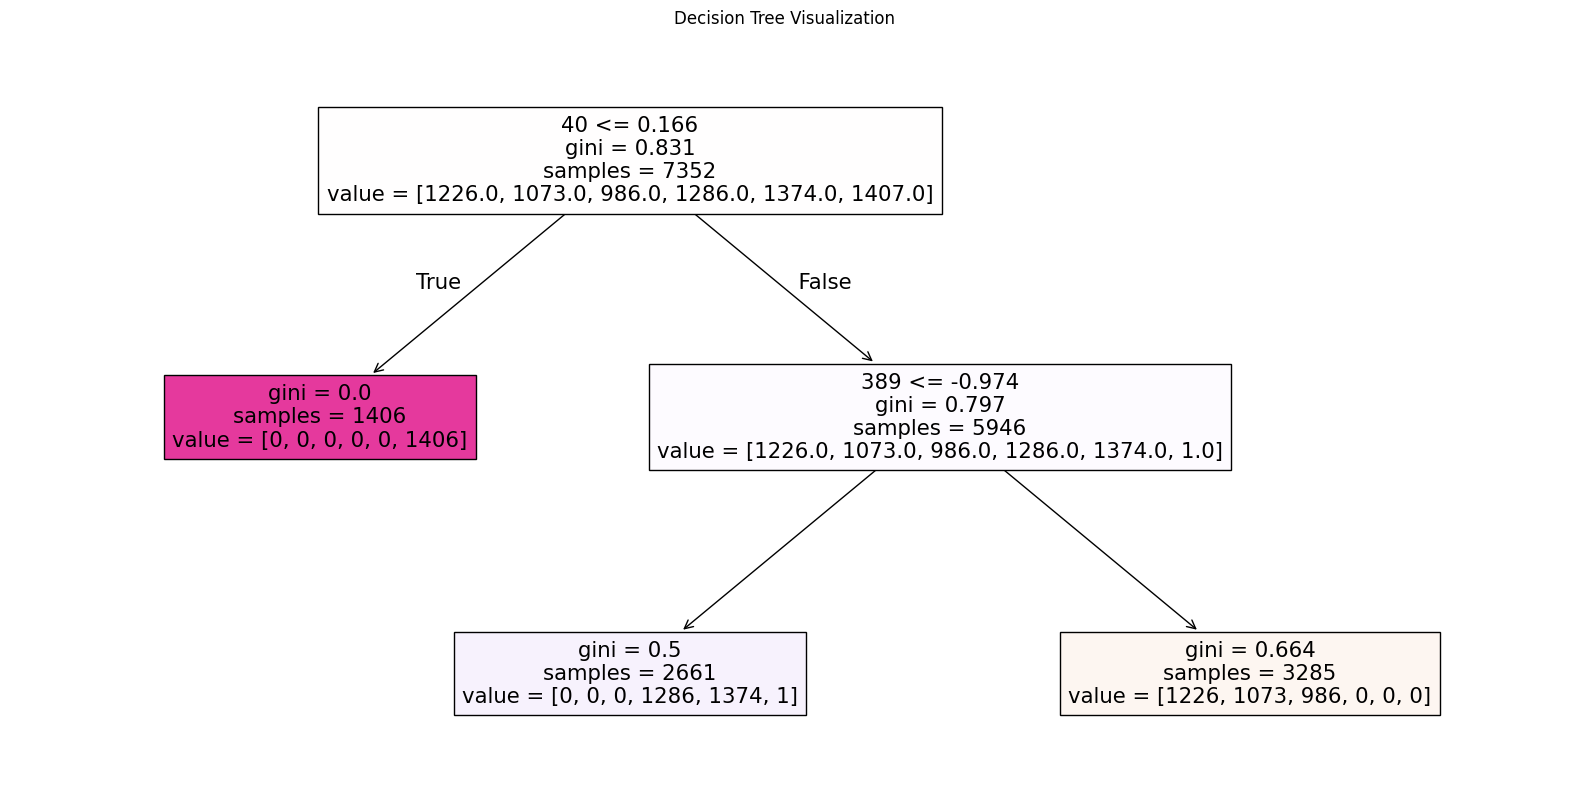

Accuracy: 0.5310485239226331
Precision: 0.33628556107901597
Recall: 0.5310485239226331
Confusion Matrix:
[[496   0   0   0   0   0]
 [471   0   0   0   0   0]
 [420   0   0   0   0   0]
 [  0   0   0   0 491   0]
 [  0   0   0   0 532   0]
 [  0   0   0   0   0 537]]

Tree of Depth : 3


c:\Users\Arjun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


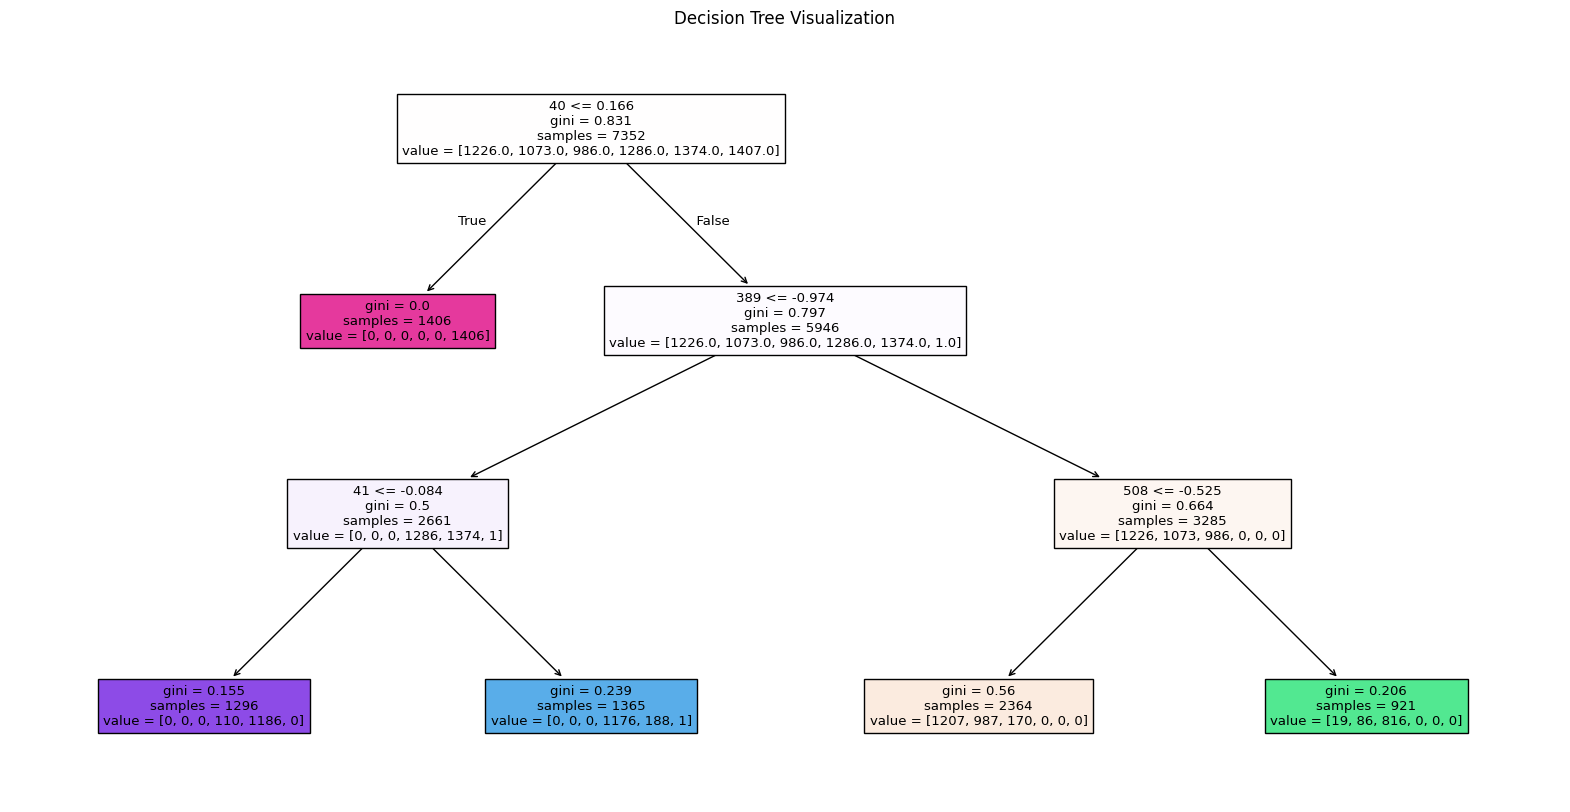

Accuracy: 0.7217509331523583
Precision: 0.6703991677890485
Recall: 0.7217509331523583
Confusion Matrix:
[[485   0  11   0   0   0]
 [463   0   8   0   0   0]
 [138   0 282   0   0   0]
 [  0   0   0 400  91   0]
 [  0   0   0 109 423   0]
 [  0   0   0   0   0 537]]

Tree of Depth : 4


c:\Users\Arjun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


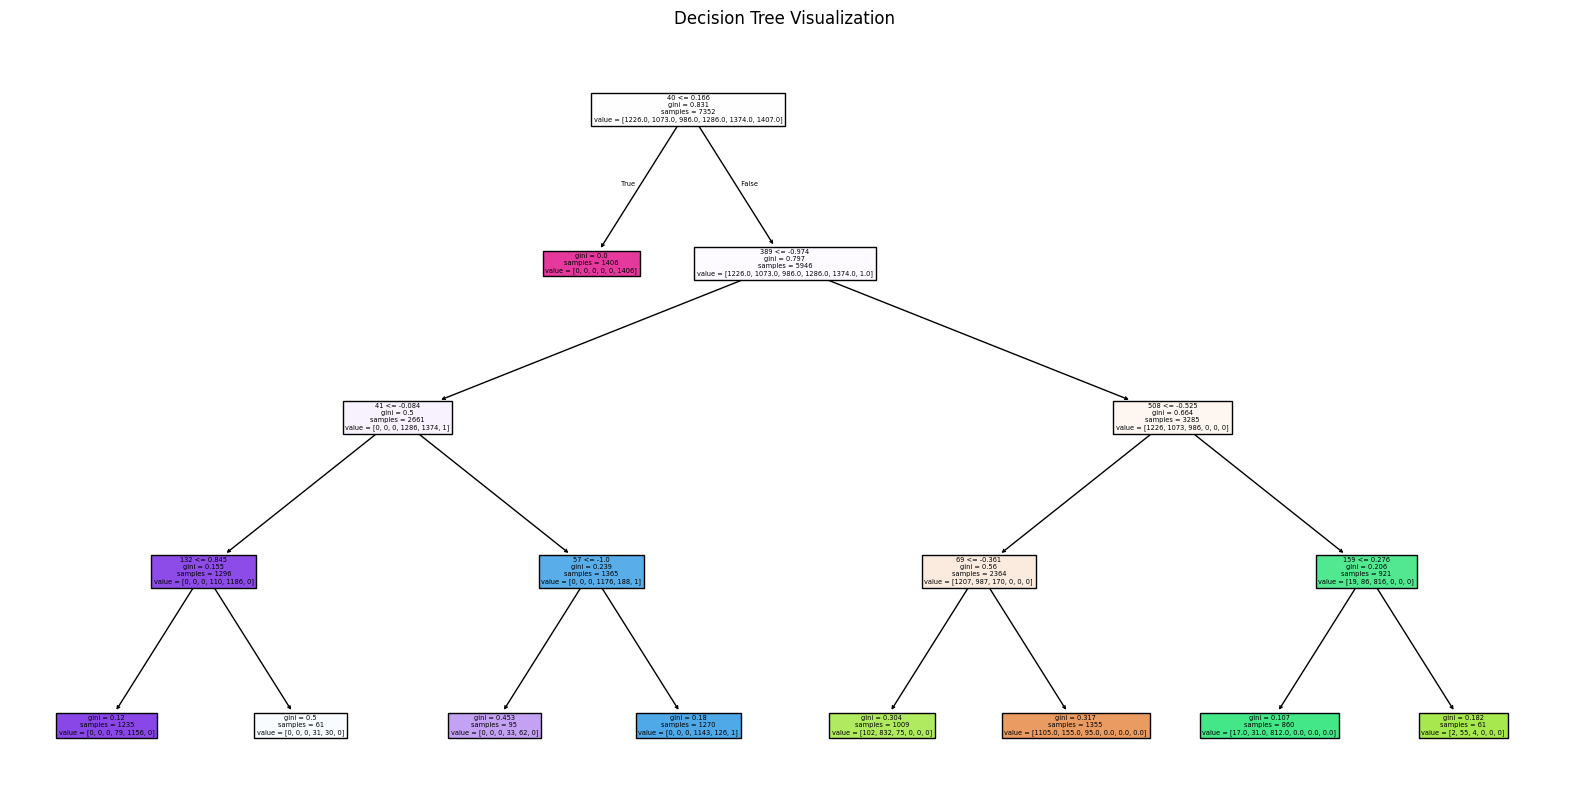

Accuracy: 0.8282999660671869
Precision: 0.8385664733180174
Recall: 0.8282999660671869
Confusion Matrix:
[[453  32  11   0   0   0]
 [ 88 377   6   0   0   0]
 [ 82  77 261   0   0   0]
 [  0   0   0 397  94   0]
 [  0   0   0 116 416   0]
 [  0   0   0   0   0 537]]

Tree of Depth : 5


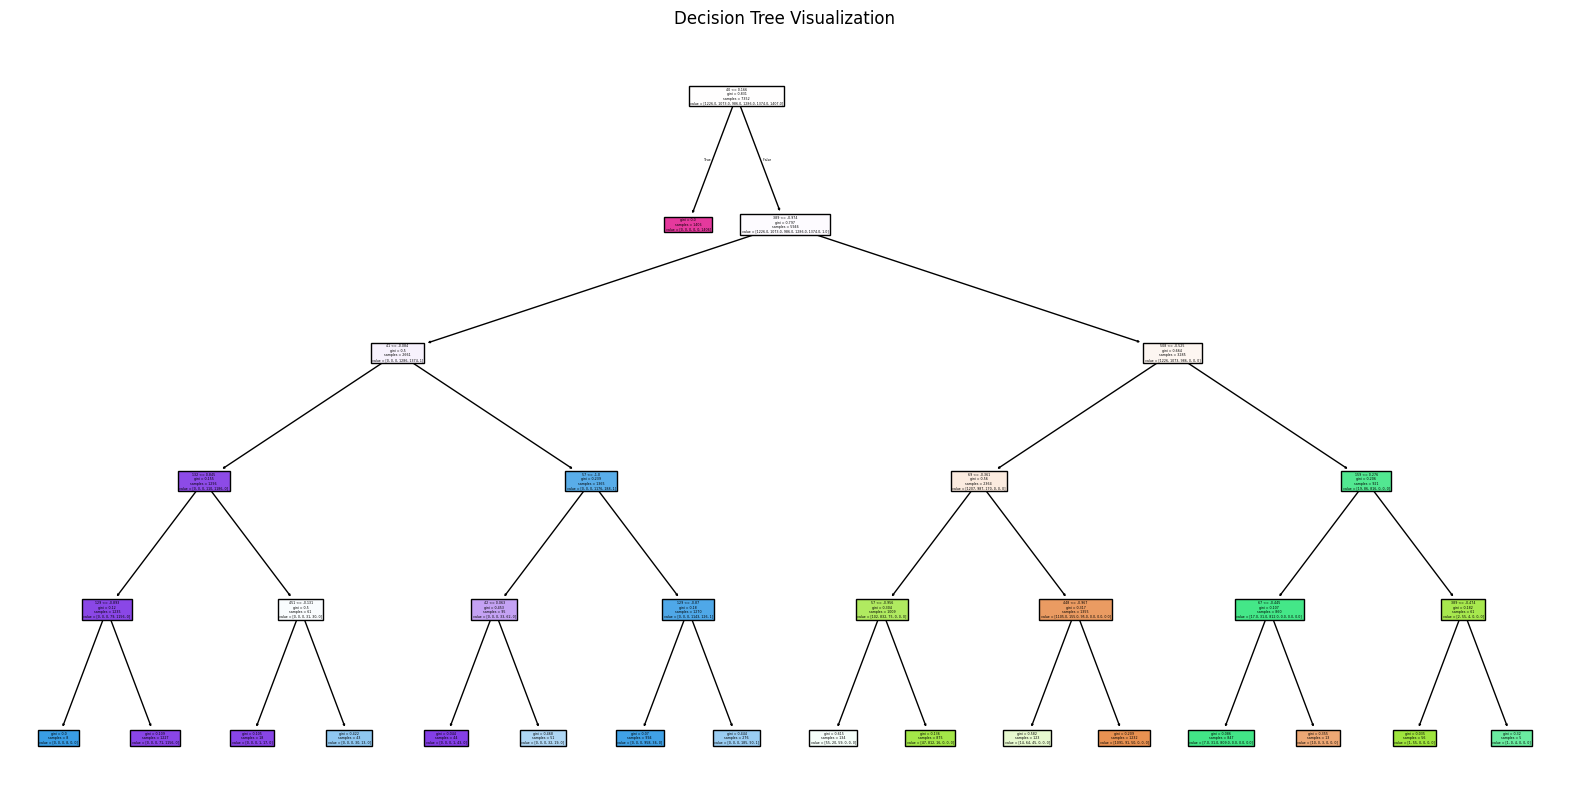

Accuracy: 0.830335934848999
Precision: 0.8301229797802715
Recall: 0.830335934848999
Confusion Matrix:
[[447  17  32   0   0   0]
 [ 44 369  58   0   0   0]
 [ 38 116 266   0   0   0]
 [  0   0   0 412  79   0]
 [  0   0   0 116 416   0]
 [  0   0   0   0   0 537]]

Tree of Depth : 6


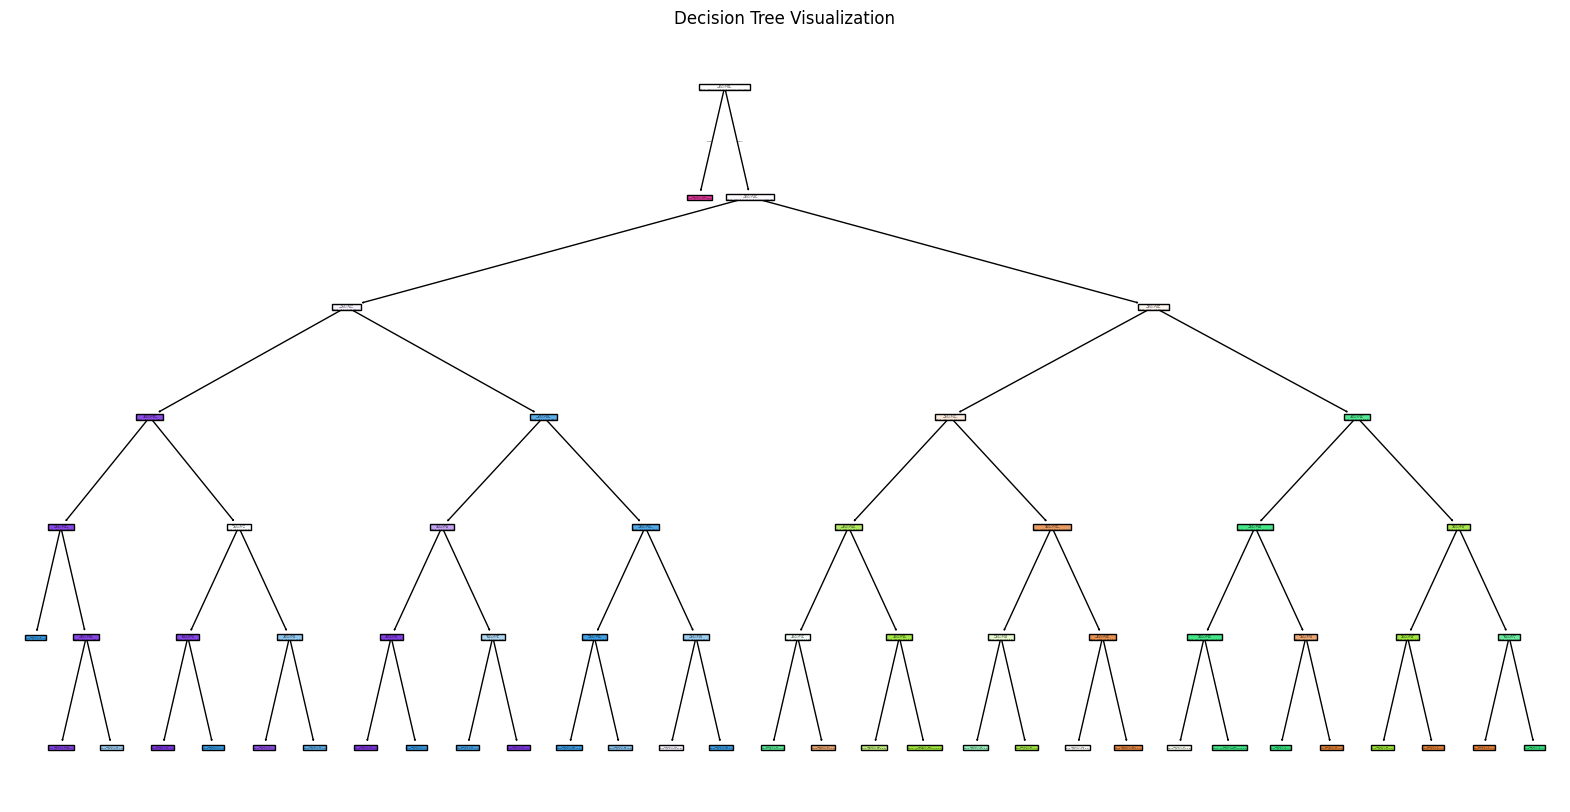

Accuracy: 0.8517136070580251
Precision: 0.8572034655859626
Recall: 0.8517136070580251
Confusion Matrix:
[[458  23  15   0   0   0]
 [ 85 359  27   0   0   0]
 [ 23  86 311   0   0   0]
 [  0   0   0 353 138   0]
 [  0   0   0  40 492   0]
 [  0   0   0   0   0 537]]

Tree of Depth : 7


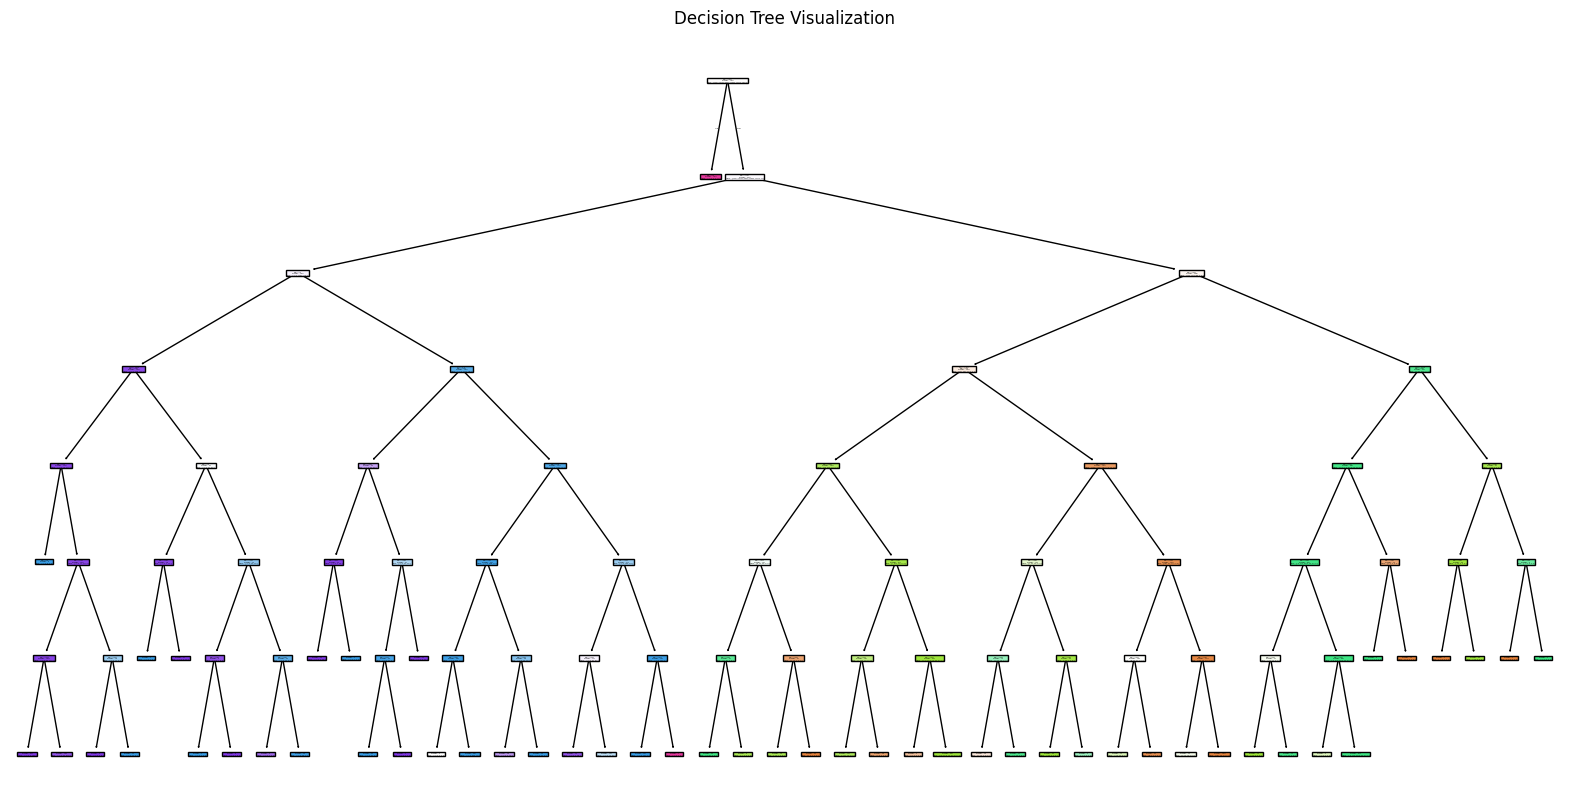

Accuracy: 0.834068544282321
Precision: 0.8387591986872436
Recall: 0.834068544282321
Confusion Matrix:
[[464  20  12   0   0   0]
 [127 319  25   0   0   0]
 [ 38  75 307   0   0   0]
 [  0   0   0 385 106   0]
 [  0   0   0  86 446   0]
 [  0   0   0   0   0 537]]

Tree of Depth : 8


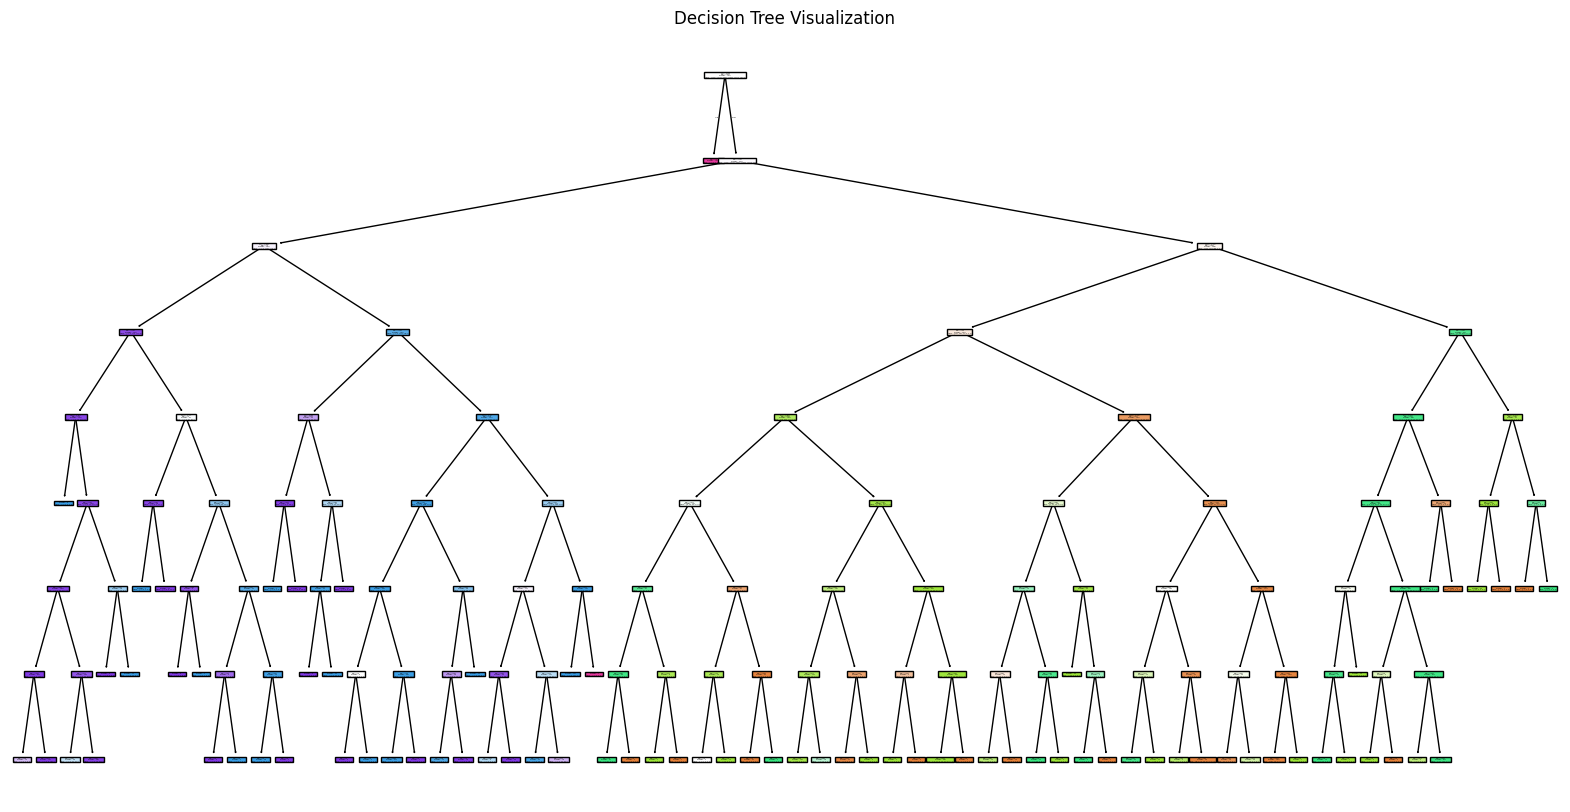

Accuracy: 0.8635900916185952
Precision: 0.865518189972163
Recall: 0.8635900916185952
Confusion Matrix:
[[464  14  18   0   0   0]
 [ 91 354  26   0   0   0]
 [ 17  68 335   0   0   0]
 [  0   0   0 382 109   0]
 [  0   0   0  59 473   0]
 [  0   0   0   0   0 537]]



In [12]:
for i in range(2,9):
    print("Tree of Depth :",i)
    decision_tree_features(depth = i)